# AIMS CDT: Machine Learning Assignment
Implementation of a neural network "from scratch".

### Import the required libraries

In [35]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random


### Import the MNIST dataset

Display a few random items

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
Number of images: 10
Image pixel size: 784 




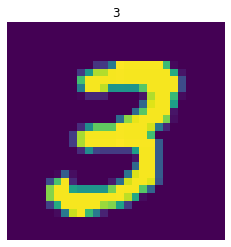

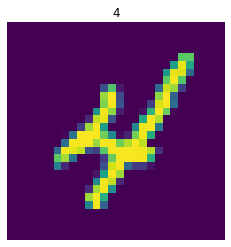

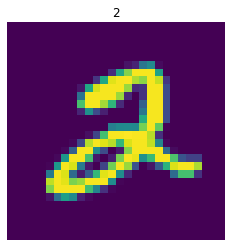

In [36]:
class Dataset(object):
    
    def __init__(self, dataset, N):

        # Create matrix where columns are images
        self.features = torch.zeros(28*28, N)
        self.classes = torch.zeros(N, dtype=torch.int8)
        self.targets = torch.zeros(10, N, dtype=torch.int8)
        
        for i, d in enumerate(dataset.data):

            # Flattened image and class
            img = d.view(-1, 28*28)
            target = dataset[i][1]
            # print(target, img)

            self.features[:, i] = img / 255.0
            self.classes[i] = target
            self.targets[target, i] = 1

            if i == N-1:
                break

    def __len__(self):
        return len(self.targets)


# Load the dataset
# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])
mnist = datasets.MNIST('../data', train=True, download=True)
                    # transform=transform)

print(mnist)

N = 10
data = Dataset(mnist, N)

# Print data stats
print('Number of images:', len(data))
print('Image pixel size:', data.features.shape[0], '\n\n')

def display_sample(i):
    '''
    Display an image sampled from the MNIST dataset.
    '''
    plt.axis('off')
    plt.title(int(data.classes[i]))
    plt.imshow(data.features[:, i].view(28,28)) # un-flatten
    plt.show()

# Display a random sample of images
N = len(data)
k = 3
samples = random.sample(range(N), k=k)

for i in samples:
    display_sample(i)



In [41]:

class Activation(object):

    def __init__(self, f='relu'):

        if f == 'sigmoid':
            self.func = self.sigmoid

        elif f == 'relu':
            self.func = self.relu

        # Default value
        else:
            self.func = self.relu

    def __call__(self, x):
        return self.func(x) 

    def sigmoid(self, x): 
        return 1/(1+torch.exp(-x))

    def relu(self, x): 
        return torch.clamp(x,0)

class Loss(object):

    def __init__(self, f='crossentropy'):
        if f == 'crossentropy':
            self.func = self.cross_entropy

        # Default value
        else:
            self.func = self.cross_entropy

    def cross_entropy(self, y_pred, y_true):
        '''
        Cross entropy for prediction probabilities x
        and true classes y.
        '''
        # loss = - torch.sum(y_true * torch.logsoftmax(y_pred, 0))
        N = y_pred.shape[1]
        loss = - torch.sum(y_true * torch.log2(torch.softmax(y_pred, 0))) / N
        # loss = torch.sum((y_true - y_pred)**2)
        # print(y_pred)

        # loss = torch.zeros(1,1)
        # for i in range(len(y_true)):
        #     loss -= torch.log2(y_pred[y_true[i], i])
            # print(y_true[i])

        return loss


    def __call__(self, y_pred, y_true):
        return self.func(y_pred, y_true)



class NeuralNetwork(object):

    def __init__(self, layers, iter=100, learning_rate=1e-4, activation='sigmoid'):

        # TODO: add bias term
        self.layers = []
        self.weights = []
        self.biases = []
        self.rate = learning_rate
        self.iter = iter

        self.create_network(layers)


        self.activation = Activation('sigmoid')

    def create_network(self, layers):

        # Create layers
        for L in layers:
            self.layers.append(torch.zeros(L, 1))

        # Create weights
        for i in range(len(layers) - 1):
            # Li is nx1, Lj is mx1 where j=i+1
            # wij is m x n 
            n, m = layers[i], layers[i+1]
            
            # Weight matrices
            # Initialised by sampling from standard normal
            # Require gradients to be computed for autograd
            self.weights.append(torch.randn(m, n, requires_grad=True))
            self.biases.append(torch.randn(1, 1, requires_grad=True))

    def forward(self, sig):
        '''
        Propagate signal forward through network.
        '''
        out = sig

        for i in range(len(self.weights)):
            out =  self.weights[i] @ out + self.biases[i]
            if i < len(self.weights) - 1:
                out = self.activation(out)

        return out

    def predict(self, out):
        return torch.argmax(out, 0)

    # def run_iteration(self, x):

        

    # def train(self):

    #     for i in range(self.iter):
    #         self.run_iteration()



In [42]:
# Load sample from dataset for training
N_train = 10000
mnist = datasets.MNIST('../data', train=True, download=True)
data_train = Dataset(mnist, N_train)

# Test data
N_test = 1000
mnist = datasets.MNIST('../data', train=False, download=True)
data_test = Dataset(mnist, N_test)


layers = [784, 128, 64, 10]
nn = NeuralNetwork(layers, activation='sigmoid')

# for i in range(len(nn.layers)):
#     print('Layer ' + str(i) + ': ' + str(nn.layers[i].shape))

# for i in range(len(nn.weights)):
#     print('Weights ' + str(i) + ': ' + str(nn.weights[i].shape))

x_train = data_train.features
y_train = data_train.classes

x_test = data_test.features
y_test = data_test.classes

iter = 1000
learning_rate = 1

compute_loss = Loss('crossentropy')

loss_history = []


for i in range(iter):

    out = nn.forward(x_train)
    y_pred = out
    y_true = data_train.targets
    # print(y_pred[:,0])

    loss = compute_loss(y_pred, y_true)
    # loss = compute_loss(y_pred, data_train.classes)

    # print('Loss:', loss.item())
    loss_history.append(loss.item())

    # Backward pass
    loss.backward()

    # Apply backward update
    with torch.no_grad():
        for j in reversed(range(len(nn.weights))):
            
            before = torch.sum(nn.weights[j])
            nn.weights[j].sub_(learning_rate * nn.weights[j].grad)
            after = torch.sum(nn.weights[j])
            # print('diff:', before.item() - after.item())
            nn.biases[j].sub_(learning_rate * nn.biases[j].grad)

            # nn.weights[j].zero_()
            # nn.biases[j].zero_()
            nn.weights[j].grad.data.zero_()
            nn.biases[j].grad.data.zero_()

    # print('\npred:', pred)
    # print('true:', data_train.classes)

    # Compute accuracy on training set
    # if i % 20 == 0:
    #     out = nn.forward(x_train)
    #     y_pred = nn.predict(out)
        
    #     correct = torch.sum(y_pred == y_train).item()
    #     acc = float(correct) / len(y_pred) * 100
    #     print('Iteration {:4d} - training accuracy {:.2f}%'.format(i, acc))


    # Compute accuracy on test set
    if i % 20 == 0:
        out = nn.forward(x_test)
        y_pred = nn.predict(out)
        
        correct = torch.sum(y_pred == y_test).item()
        acc = float(correct) / len(y_pred) * 100
        print('Iteration {:4d} - test accuracy {:.2f}%'.format(i, acc))


print('\n\nTraining completed')

# plt.yscale('log')
plt.plot(loss_history)



Iteration    0 - test accuracy 8.60%
Iteration   20 - test accuracy 48.70%
Iteration   40 - test accuracy 61.70%
Iteration   60 - test accuracy 67.40%
Iteration   80 - test accuracy 71.50%
Iteration  100 - test accuracy 74.30%
Iteration  120 - test accuracy 76.40%
Iteration  140 - test accuracy 76.80%


KeyboardInterrupt: 